# setup and Data Download 

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

# --- Define Parameters ---
START_DATE = '2015-01-01'
END_DATE = '2025-10-31'
MARKET_TICKER = '^GSPC' # Proxy for the US Market

# --- A. Download Market Index Data ---
print(f"Downloading {MARKET_TICKER} data...")
df_market = yf.download(MARKET_TICKER, start=START_DATE, end=END_DATE, progress=False)

# Handle cases where the downloaded object might be empty or the expected column is missing
if df_market is None or df_market.empty:
	raise ValueError(f"No market data downloaded for {MARKET_TICKER} between {START_DATE} and {END_DATE}. "
					 "Please check the ticker and date range.")

# Prefer 'Adj Close' but fall back to 'Close' if necessary
if 'Adj Close' in df_market.columns:
	market_price = df_market['Adj Close']
elif 'Close' in df_market.columns:
	market_price = df_market['Close']
else:
	# If a multi-index or unexpected structure, try to locate a close/adj close column
	cols_lower = [c.lower() if isinstance(c, str) else '' for c in df_market.columns]
	if 'adj close' in cols_lower:
		market_price = df_market.iloc[:, cols_lower.index('adj close')]
	elif 'close' in cols_lower:
		market_price = df_market.iloc[:, cols_lower.index('close')]
	else:
		raise KeyError("Could not find 'Adj Close' or 'Close' in downloaded market data columns: "
					   f"{list(df_market.columns)}")

# --- B. Calculate Daily Market Return (R_m) ---
market_returns = market_price.pct_change().dropna()
print("Market returns calculated.")


/var/folders/00/c54qzf757tzdyqs5hr4n94vc0000gn/T/ipykernel_36137/2321497377.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_market = yf.download(MARKET_TICKER, start=START_DATE, end=END_DATE, progress=False)


Market returns calculated.


# Import Risk Free and Alignment 

In [3]:
# Load real daily returns from yfinance (returns_daily.csv)
portfolio_returns = pd.read_csv(
	"daily_returns.csv",  # file saved from your yfinance notebook
	index_col=0,
	parse_dates=True
)

print("portfolio_returns head:")
print(portfolio_returns.head())
print("portfolio_returns dates:", portfolio_returns.index.min(), "to", portfolio_returns.index.max())

# Load real daily risk-free from FRED (rf_daily.csv)
rf_aligned_final = pd.read_csv(
	"rf_daily.csv",  # file saved from your FRED notebook
	index_col=0,
	parse_dates=True
)

# If it loads as a DataFrame, take the first numeric column as a Series
if isinstance(rf_aligned_final, pd.DataFrame):
	if rf_aligned_final.shape[1] == 1:
		rf_aligned_final = rf_aligned_final.iloc[:, 0]
	else:
		numeric_cols_rf = rf_aligned_final.select_dtypes(include=[np.number]).columns
		if len(numeric_cols_rf) == 0:
			raise ValueError("rf_daily.csv has no numeric columns to use as risk-free series.")
		rf_aligned_final = rf_aligned_final[numeric_cols_rf[0]]

# Ensure rf_aligned_final is a Series
if isinstance(rf_aligned_final, pd.DataFrame):
	rf_aligned_final = rf_aligned_final.squeeze()

print("\nrf_aligned_final head:")
print(rf_aligned_final.head())
print("rf_aligned_final dates:", rf_aligned_final.index.min(), "to", rf_aligned_final.index.max())

# Align dates and compute excess returns (Rp - Rf)
common_index = portfolio_returns.index.intersection(rf_aligned_final.index)
print("\nCommon trading days:", len(common_index))

# Align both on the common index
pr_aligned = portfolio_returns.loc[common_index].copy()
rf_aligned = rf_aligned_final.loc[common_index]

# Compute excess returns for each numeric column in the portfolio
numeric_cols = pr_aligned.select_dtypes(include=[np.number]).columns
if len(numeric_cols) == 0:
	raise ValueError("No numeric columns found in portfolio_returns.")

for col in numeric_cols:
	pr_aligned[f"{col}_EX"] = pr_aligned[col] - rf_aligned

print("\nExcess returns added (first 5 rows):")
print(pr_aligned.head())

portfolio_returns head:
                 CVX      ENPH       EOG       NEE      TSLA       XOM
Date                                                                  
2015-01-05 -0.039971 -0.023223 -0.060277 -0.010591 -0.042041 -0.027362
2015-01-06 -0.000462 -0.067723 -0.028496  0.003884  0.005664 -0.005316
2015-01-07 -0.000833 -0.119011 -0.006293  0.009153 -0.001562  0.010132
2015-01-08  0.022883  0.028947  0.038241  0.006078 -0.001564  0.016645
2015-01-09 -0.019926 -0.017050  0.006676 -0.008830 -0.018802 -0.001410
portfolio_returns dates: 2015-01-05 00:00:00 to 2025-10-30 00:00:00

rf_aligned_final head:
Date
2015-01-05    1.190476e-06
2015-01-06    1.190476e-06
2015-01-07    1.190476e-06
2015-01-08    1.190476e-06
2015-01-09    7.936508e-07
Name: 0, dtype: float64
rf_aligned_final dates: 2015-01-05 00:00:00 to 2025-10-30 00:00:00

Common trading days: 2723

Excess returns added (first 5 rows):
                 CVX      ENPH       EOG       NEE      TSLA       XOM  \
Date             

# Basket

In [4]:
green_tickers = ["ENPH", "TSLA", "NEE"]
brown_tickers = ["CVX", "XOM", "EOG"]
all_tickers = green_tickers + brown_tickers

In [5]:

# Equal-weighted daily excess returns for each basket
green_cols = [f"{t}_EX" for t in green_tickers]
brown_cols = [f"{t}_EX" for t in brown_tickers]

# Ensure required excess-return columns exist
missing_green = [c for c in green_cols if c not in pr_aligned.columns]
missing_brown = [c for c in brown_cols if c not in pr_aligned.columns]
if missing_green or missing_brown:
	raise KeyError(f"Missing excess return columns. Missing green: {missing_green}, missing brown: {missing_brown}")

green_excess = pr_aligned[green_cols].mean(axis=1)
brown_excess = pr_aligned[brown_cols].mean(axis=1)

green_excess.name = "Green_Excess"
brown_excess.name = "Brown_Excess"

print("Green excess head:")
print(green_excess.head())
print("\nBrown excess head:")
print(brown_excess.head())

Green excess head:
Date
2015-01-05   -0.025286
2015-01-06   -0.019393
2015-01-07   -0.037141
2015-01-08    0.011153
2015-01-09   -0.014895
Name: Green_Excess, dtype: float64

Brown excess head:
Date
2015-01-05   -0.042538
2015-01-06   -0.011426
2015-01-07    0.001001
2015-01-08    0.025922
2015-01-09   -0.004887
Name: Brown_Excess, dtype: float64


# Compute performance metrics (CAGR, volatility, Sharpe)

In [6]:
def compute_metrics(excess_series):
	"""excess_series is daily excess return (Rp - Rf).
	Returns a dict with:
	 - n_days, mean_daily, vol_daily,
	 - mean_annual, vol_annual, sharpe, cagr
	"""
	if excess_series is None or len(excess_series) == 0:
		raise ValueError("excess_series must be a non-empty Series or array-like.")

	n_days = len(excess_series)
	mean_daily = excess_series.mean()
	vol_daily = excess_series.std()

	# Annualize (assume 252 trading days)
	trading_days = 252
	mean_annual = mean_daily * trading_days
	vol_annual = vol_daily * np.sqrt(trading_days)

	# Sharpe (annualized mean / annualized vol)
	sharpe = mean_annual / vol_annual if vol_annual != 0 else np.nan

	# Geometric annualized return (CAGR) computed from daily excess returns
	# (1 + r_t) product -> annualize by (trading_days / n_days)
	cum_prod = (1 + excess_series).prod()
	cagr = cum_prod ** (trading_days / n_days) - 1

	return {
		"n_days": n_days,
		"mean_daily": mean_daily,
		"vol_daily": vol_daily,
		"mean_annual": mean_annual,
		"vol_annual": vol_annual,
		"sharpe": sharpe,
		"cagr": cagr,
	}

In [7]:
# Compute and display metrics for the green and brown baskets using the existing compute_metrics function
for label, series in [("Green", green_excess), ("Brown", brown_excess)]:
    metrics = compute_metrics(series)
    print(f"{label} basket metrics:")
    print(f"  CAGR:       {metrics['cagr']:.6%}")
    print(f"  Volatility: {metrics['vol_annual']:.6%}")
    print(f"  Sharpe:     {metrics['sharpe']:.4f}")
    print()


Green basket metrics:
  CAGR:       27.686495%
  Volatility: 39.925702%
  Sharpe:     0.8115

Brown basket metrics:
  CAGR:       4.840446%
  Volatility: 29.586632%
  Sharpe:     0.3084



# Cumulative excess return chart (green vs brown)

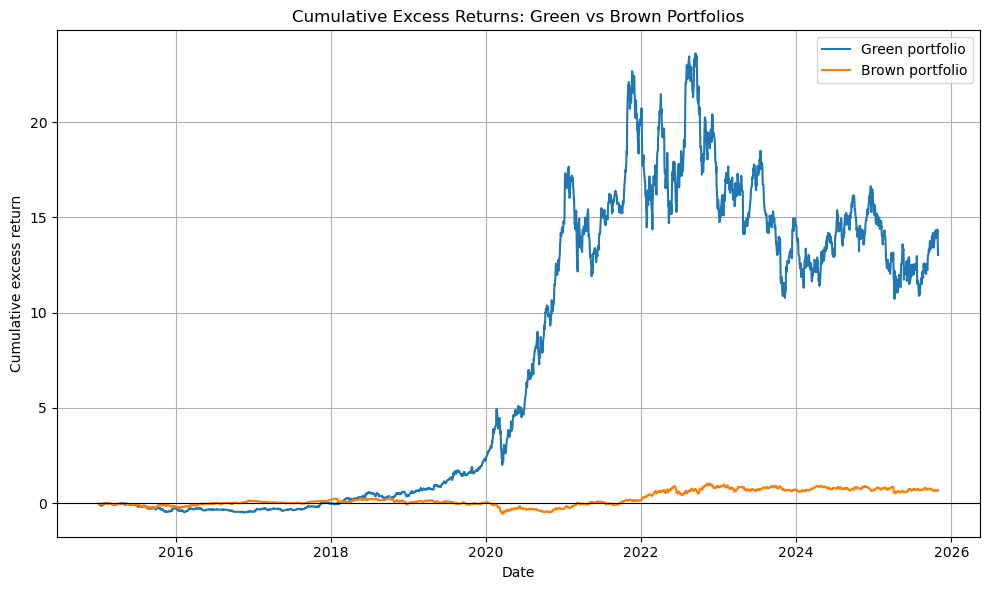

In [8]:
import matplotlib.pyplot as plt

# Cumulative excess returns: (1 + r).cumprod() - 1
green_cum = (1 + green_excess).cumprod() - 1
brown_cum = (1 + brown_excess).cumprod() - 1

plt.figure(figsize=(10, 6))
plt.plot(green_cum.index, green_cum, label="Green portfolio")
plt.plot(brown_cum.index, brown_cum, label="Brown portfolio")
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Cumulative Excess Returns: Green vs Brown Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative excess return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Put metrics in a table and (optionally) save

In [9]:
# Compute and store metrics for each basket (fix for undefined variables)
green_metrics = compute_metrics(green_excess)
brown_metrics = compute_metrics(brown_excess)

metrics_df = pd.DataFrame(
	[green_metrics, brown_metrics],
	index=["Green", "Brown"]
)

print("\nBasket metrics:")
print(metrics_df)

# Optionally save to CSV
metrics_df.to_csv("basket_metrics.csv")
print("\nMetrics saved to basket_metrics.csv")


Basket metrics:
       n_days  mean_daily  vol_daily  mean_annual  vol_annual    sharpe  \
Green    2723    0.001286   0.025151     0.323987    0.399257  0.811474   
Brown    2723    0.000362   0.018638     0.091237    0.295866  0.308372   

           cagr  
Green  0.276865  
Brown  0.048404  

Metrics saved to basket_metrics.csv
